## Dans ce code ci matlab et python on une initialisation des hyperparamètres avant la phase d'optimisation identique.

In [41]:
import math
import torch
import matplotlib.pyplot as plt
import pandas as pd
import gpytorch
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  Visualisation et traitement des données

In [42]:
# ########################################################
X_train = pd.read_csv('xtraining_matlab.csv')
X_train = torch.DoubleTensor(X_train.xtraining.to_numpy())

Y_train = pd.read_csv('ytraining_matlab.csv')
Y_train = torch.DoubleTensor(Y_train.ytraining.to_numpy())

# ########################################################
X_test = pd.read_csv('xtest_matlab.csv')
X_test = torch.DoubleTensor(X_test.xtest.to_numpy())

Y_test = pd.read_csv('ytest_matlab.csv')
Y_test = torch.DoubleTensor(Y_test.ytest.to_numpy())

# ########################################################

data01 = pd.read_csv('GHI_20190423_20190713_10min.csv')
data01.rename(
    columns={'Time':'Date'},inplace=True)
data01['Date'] = pd.to_datetime(data01['Date'])

date_train = data01['Date'][0:2118]
date_test = data01['Date'][2118:2414]

# ########################################################

Y_MU = pd.read_csv('YMU_matlab.csv')

# ########################################################
print(X_train.shape)
# print(Y_train.shape)

print(X_test.shape)
# print(Y_test.shape)

print(date_train.shape)
print(date_test.shape)

torch.Size([2118])
torch.Size([296])
(2118,)
(296,)


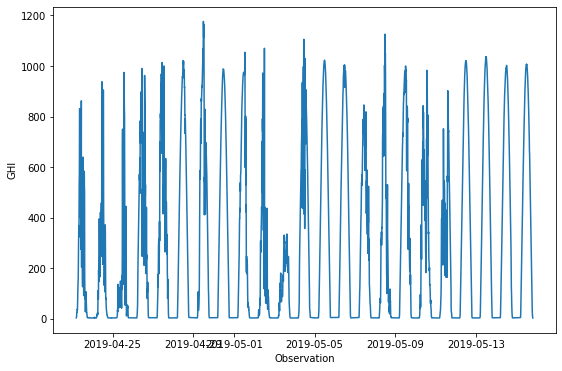

In [43]:
plt.figure(figsize=(9,6))
plt.plot(date_train,Y_train)
plt.xlabel('Observation')
plt.ylabel('GHI')
plt.show()

# Création d'un modèle de Régression par GP

In [44]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self,X_train, Y_train,likelihood):
        super(ExactGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        
        PeriodicKernel =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        RQKernel =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
        
        self.covar_module = gpytorch.kernels.ProductKernel(PeriodicKernel,RQKernel)
        
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

In [45]:
# Initialisation de la loi de probabilités et du modele de processus Gaussien
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, Y_train, likelihood)

## Initialisation des hyperparamètres

In [46]:
hyp_matlab =[0.2298,-0.0013,-0.6986,-2.7964,-1.5327,-3.1434]
hyp_python = []
for n in hyp_matlab:
    exp_matlab = np.exp(n)
    hyp_python.append(exp_matlab)
    print(exp_matlab)
    
print("\n",hyp_python)

1.258348315097814
0.9987008446339523
0.4972810100974997
0.06102937337315947
0.2159518095768952
0.04313588628038074

 [1.258348315097814, 0.9987008446339523, 0.4972810100974997, 0.06102937337315947, 0.2159518095768952, 0.04313588628038074]


In [47]:
model.likelihood.initialize(noise=0.1)

##################################################################
# Initialisation du noyau Periodic
model.covar_module.kernels[0].base_kernel.initialize(lengthscale=1.2583)
model.covar_module.kernels[0].base_kernel.initialize(period_length=0.9987)
model.covar_module.kernels[0].initialize(outputscale=0.4972)

##################################################################
# Initialisation du noyau RQ
model.covar_module.kernels[1].base_kernel.initialize(lengthscale=0.0610)
model.covar_module.kernels[1].initialize(outputscale=0.2159)
model.covar_module.kernels[1].base_kernel.initialize(alpha=0.0431)

##################################################################
# Affichage des valeurs initilaisés
print('Noise :',model.likelihood.noise_covar.noise,"\n")
print('Peridoc Kernel lengthscale [L(P)]:',model.covar_module.kernels[0].base_kernel.lengthscale)
print('périod_length [p_length] :',model.covar_module.kernels[0].base_kernel.period_length,"\n")
print('Periodic outputscale [p_sig]:',model.covar_module.kernels[0].outputscale)

print('RQ lengthscale L(RQ):',model.covar_module.kernels[1].base_kernel.lengthscale)
print('RQ outputscale :',model.covar_module.kernels[1].outputscale)
print('Alpha : ',model.covar_module.kernels[1].base_kernel.alpha)

Noise : tensor([0.1000], grad_fn=<AddBackward0>) 

Peridoc Kernel lengthscale [L(P)]: tensor([[1.2583]], grad_fn=<SoftplusBackward>)
périod_length [p_length] : tensor([[0.9987]], grad_fn=<SoftplusBackward>) 

Periodic outputscale [p_sig]: tensor(0.4972, grad_fn=<SoftplusBackward>)
RQ lengthscale L(RQ): tensor([[0.0610]], grad_fn=<SoftplusBackward>)
RQ outputscale : tensor(0.2159, grad_fn=<SoftplusBackward>)
Alpha :  tensor([0.0431], grad_fn=<SoftplusBackward>)


## Entrainement du modèle et optimisation des hyperparamètres(kernel et moyenne)

In [48]:
# Entrainement du modèle afin de trouver les paramètres approximant au mieux nos données
model = model.double()
model.train()
likelihood.train()

# Algorithme d'optimisation, ici "Adam" sera utilisé pour optimiser les valeurs des hyperparamètres de chaque kernel
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.375)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [49]:
training_iter = 100

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    
    
    # the way the PyTorch optimizer works is that it looks for a variable called loss,
    # which also has a gradient (calc by calling backward), and tries to reduce it.
    loss = -mll(output, Y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   L(P): %.3f  p_length: %.3f p_sig: %.3f  L(RQ): %.3f  RQ_sig: %.3f Alpha: %.3f  ' % (
        i + 1, training_iter, loss,
        model.covar_module.kernels[0].base_kernel.lengthscale,
        model.covar_module.kernels[0].base_kernel.period_length,
        model.covar_module.kernels[0].outputscale,
        model.covar_module.kernels[1].base_kernel.lengthscale,
        model.covar_module.kernels[1].outputscale,
        model.covar_module.kernels[1].base_kernel.alpha,
#         model.likelihood.noise
    ))
    optimizer.step()

c:\users\dem\appdata\local\programs\python\python37\lib\site-packages\gpytorch\utils\linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ..\aten\src\ATen\native\Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iter 1/100 - Loss: 58254.412   L(P): 1.258  p_length: 0.999 p_sig: 0.497  L(RQ): 0.061  RQ_sig: 0.216 Alpha: 0.043  
Iter 2/100 - Loss: 63221.158   L(P): 1.005  p_length: 1.251 p_sig: 0.661  L(RQ): 0.042  RQ_sig: 0.301 Alpha: 0.062  
Iter 3/100 - Loss: 33529.194   L(P): 0.784  p_length: 1.404 p_sig: 0.857  L(RQ): 0.029  RQ_sig: 0.410 Alpha: 0.088  
Iter 4/100 - Loss: 18305.001   L(P): 0.605  p_length: 1.527 p_sig: 1.078  L(RQ): 0.021  RQ_sig: 0.546 Alpha: 0.123  
Iter 5/100 - Loss: 11964.529   L(P): 0.465  p_length: 1.579 p_sig: 1.308  L(RQ): 0.015  RQ_sig: 0.699 Alpha: 0.164  
Iter 6/100 - Loss: 8603.498   L(P): 0.365  p_length: 1.621 p_sig: 1.537  L(RQ): 0.012  RQ_sig: 0.865 Alpha: 0.210  
Iter 7/100 - Loss: 6928.470   L(P): 0.297  p_length: 1.657 p_sig: 1.761  L(RQ): 0.010  RQ_sig: 1.039 Alpha: 0.257  
Iter 8/100 - Loss: 6031.702   L(P): 0.251  p_length: 1.690 p_sig: 1.977  L(RQ): 0.008  RQ_sig: 1.215 Alpha: 0.303  
Iter 9/100 - Loss: 5408.092   L(P): 0.221  p_length: 1.719 p_sig: 2

Iter 72/100 - Loss: 455.074   L(P): 0.318  p_length: 1.998 p_sig: 5.137  L(RQ): 0.005  RQ_sig: 4.305 Alpha: 0.174  
Iter 73/100 - Loss: 450.677   L(P): 0.315  p_length: 2.000 p_sig: 5.144  L(RQ): 0.005  RQ_sig: 4.313 Alpha: 0.171  
Iter 74/100 - Loss: 446.917   L(P): 0.312  p_length: 2.002 p_sig: 5.152  L(RQ): 0.005  RQ_sig: 4.321 Alpha: 0.169  
Iter 75/100 - Loss: 443.791   L(P): 0.309  p_length: 2.003 p_sig: 5.160  L(RQ): 0.005  RQ_sig: 4.328 Alpha: 0.166  
Iter 76/100 - Loss: 440.781   L(P): 0.307  p_length: 2.004 p_sig: 5.168  L(RQ): 0.005  RQ_sig: 4.336 Alpha: 0.164  
Iter 77/100 - Loss: 437.701   L(P): 0.304  p_length: 2.004 p_sig: 5.175  L(RQ): 0.005  RQ_sig: 4.343 Alpha: 0.161  
Iter 78/100 - Loss: 434.512   L(P): 0.301  p_length: 2.004 p_sig: 5.183  L(RQ): 0.005  RQ_sig: 4.351 Alpha: 0.159  
Iter 79/100 - Loss: 431.316   L(P): 0.297  p_length: 2.002 p_sig: 5.190  L(RQ): 0.005  RQ_sig: 4.358 Alpha: 0.157  
Iter 80/100 - Loss: 428.407   L(P): 0.294  p_length: 2.001 p_sig: 5.197 

## Validation du modèle et visualisation des résultats

In [50]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

A chaque pas de temps  il faut :
- 1.) Prédire la prochaine valeur en fonction des données précédente
- 2.) Instiller dans le modèle l'observation que l'on cherche a prédire, de tel sorte a mettre a jour le modèle et optimiser ses prédictions

In [51]:
X_data = X_train
Y_data = Y_train

hp = 1
n = 0

mini_test = torch.tensor(())
Y_pred = torch.DoubleTensor()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    
    #réponse du modèle aux données d'entrainement (ici la date)
    pred_train = likelihood(model(X_train))
    
    #Boucle permettant la prédiction sur un horizon de prédiction
    for i in range (0,len(X_test)+1,hp):
        
#         ind = i+hp
        
        # 1. -- tenseur regroupant la/les observation a fournir au modele. il est évidemment different a chaque pas de temps
        mini_test = X_test[i:i+hp]
        
        # phase de test : réponse du modèle a/aux observation donnée(s)
        pred_01 = likelihood(model(mini_test)).loc
        
        # tenseur final regroupant toutes les réponses/prédictions du modèle ayant été faite à chaque pas de temps
        Y_pred = torch.cat((Y_pred,pred_01),0)
        
        
        # 2. -- tenseur regroupant les nouvelles observations permettant de mettre a jour le modèle.
        # A chaque itération on fourni donc au modèle toutes les précedente observations
        a1 = X_test[i:i+hp]
        a2 = Y_test[i:i+hp]
        X_data = torch.cat((X_data,a1),0)
        Y_data = torch.cat((Y_data,a2),0)
        
        # permet de fournir/mettre a jour le modèle avec de nouvelle donnée a chaque pas de temps
        # l'argument "strict" si il est faux autorise l'insertion dans le modèle des données n'ayant pas les mêmes
        # dimensions que celles fournis originellement au modèle.
        model.set_train_data(X_data,Y_data,strict=False)
        
#         print(n)
#         n = n+1
#         load = round(0.33783783783783783*n)
#         print(load,"%")

c:\users\dem\appdata\local\programs\python\python37\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


<IPython.core.display.Javascript object>


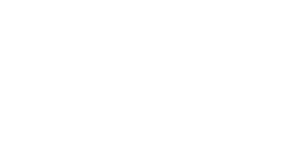

In [52]:
%matplotlib notebook
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(10,6))
    
###############################################

    # Plot training data as black stars
    ax.plot(date_train, Y_train, '-ko')
    # Get upper and lower confidence bounds
    lower, upper = pred_train.confidence_region()
    ax.fill_between(date_train, lower.numpy(), upper.numpy(), alpha=0.9)
    # Plot train means 
    ax.plot(date_train, pred_train.mean.numpy(), '-b')
    
    
###############################################

    # Plot test data as red stars
    ax.plot(date_test,Y_test, '-ro')
    # Plot predictive means 
    ax.plot(date_test, Y_pred.numpy(), '-go')
    # Confidence interval
    ci = 1.96 * torch.std(Y_pred)/torch.mean(Y_pred)
    ax.fill_between(date_test, (Y_pred-ci), (Y_pred+ci), color='b', alpha=0.8)
    
    plt.xlabel('Date')
    plt.ylabel('GHI ($W/m^2$)')
    plt.title('Résultat d entrainement et de test avec mis a jour/10 min')
    ax.legend(['Data training', 'Réponse du modele','Data test' ,'Réponse du modèle','95 % CI'])

<IPython.core.display.Javascript object>


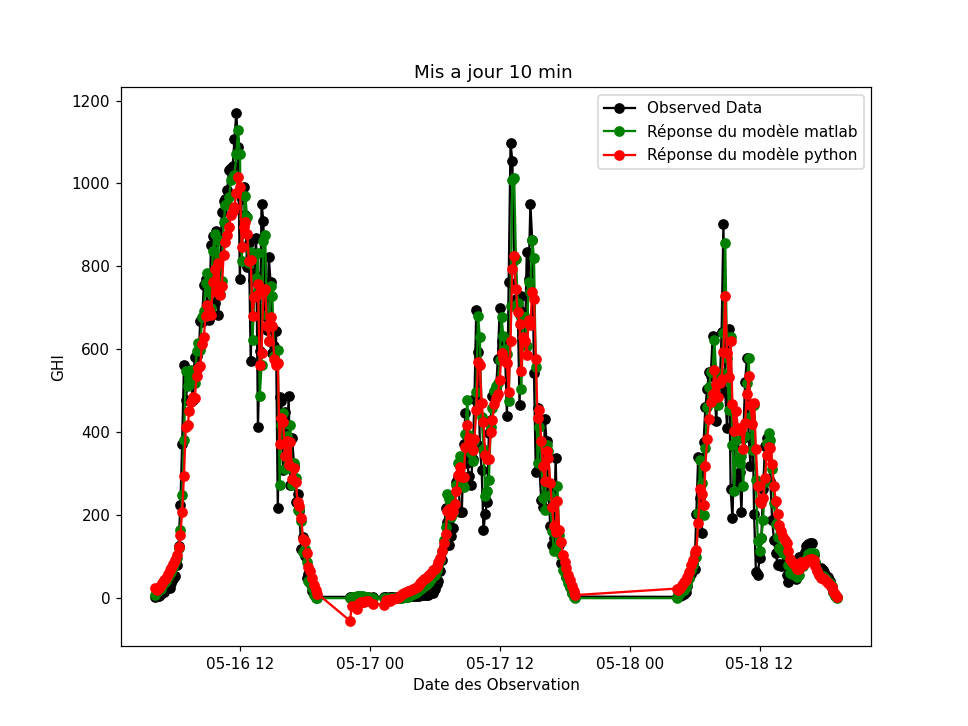

In [53]:
###############################################
# Tracé de matlab 

%matplotlib notebook
plt.figure(figsize=(8,6))
plt.plot(date_test, Y_test, '-ko')
plt.plot(date_test,Y_MU,'-go')
plt.plot(date_test,Y_pred,'-ro')
plt.title("Mis a jour 10 min ")
plt.xlabel('Date des Observation')
plt.ylabel('GHI')
plt.legend(['Observed Data', 'Réponse du modèle matlab', 'Réponse du modèle python'])
plt.show()

### Condition initiale :
-	Vecteur des hyperparamètre :

hyperparamètres issue de matlab :  [0.2298   -0.0013   -0.6986   -2.7964   -1.5327   -3.1434]

Fonction exp appliqué au vecteur (hyp) : [1.2583, 0.9987, 0.4972, 0.0610, 0.2159, 0.0431]

### Nombre d'itération = 100

## <u> Résultats finaux </u>


### <u> Fonction de covariance périodique <u> :

#### Matlab :
- Lenghtscale (L) = 0.8285
- Periodic lengthscale = 0.9996
- Outputscale ($\sigma$) = 23.8861

#### Python :
- Lenghtscale (L) = 0.241
- Periodic lengthscale = 2.002
- Outputscale ($\sigma$) = 5.336


### <u>Fonction de covariance RQ <u>:

#### Matlab :
- Lenghtscale (L) = 0.0340
- Outputscale ($\sigma$) = 10.3729
- RQ lengthscale = 0.0687 


#### Python :
- Lenghtscale (L) = 0.004
- Outputscale ($\sigma$) = 4.503
- RQ lengthscale = 0.132



    
### <u>Fonction de vraisemblance marginale (loss) </u>:
    
#### Matlab : 12355

#### Python : 392.361


    
### <u> Mean squared error (MSE) </u>:    
    
#### Matlab : 11 168

#### Python : 12 028    
    
    
### <u> Root Mean squared error (RMSE) </u>:    
    
#### Matlab : 105.6773

#### Python : 109.6     
    
    

In [54]:
MSE = mean_squared_error(Y_test,Y_pred)
RMSE = (np.sqrt(MSE))
print("MSE :",MSE)
print("RMSE :",RMSE)

MSE : 12014.50183699864
RMSE : 109.61068304229583
